# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image

# Library untuk preprocessing data
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

# Library untuk membangun model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50  # Arsitektur ResNet50 
from tensorflow.keras.optimizers import Adam


# Defining Necessary Functions

In [2]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (128, 128))  # ResNet50 expects input size 
            return img_to_array(image)  # Normalize to [0, 1]
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    image_list, label_list = [], []
    for directory in listdir(data_dir):  # Folder names act as labels
        folder_path = os.path.join(data_dir, directory)
        if os.path.isdir(folder_path):  # Check if the path is a directory
            for file in listdir(folder_path):  # Iterate through files in the folder
                image_path = os.path.join(folder_path, file)
                image = convert_image_to_array(image_path)
                if image.size != 0:
                    image_list.append(image)
                    label_list.append(directory)  # Use folder name as label
    return np.array(image_list), np.array(label_list)

# Function to visualize predictions
def output_plot(image, model, class_labels):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Make prediction with the model
    predictions = model.predict(image.reshape(1, 224, 224, 3))

    # Display the input image
    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')
    
    # Display prediction probabilities
    prediction_values = predictions[0]
    max_index = np.argmax(prediction_values)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])
    axs[1].set_title('Predictions')

    plt.tight_layout()
    plt.show()


# Loading Data

In [3]:

dir_path = r"C:/Users/USER/PM/PROJECT MACHINE LEARNING/Dataset"
all_labels = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
binary_labels = [int(i) for i in range(len(all_labels))]
images, labels = load_dataset(dir_path)

In [4]:
!pip install opencv-python

In [5]:
!pip install tensorflow


In [6]:
!pip install pillow

In [7]:
all_labels

['Antraknosa', 'Cendawan Jelaga', 'Ulat daun']

In [8]:
# Mengimpor fungsi train_test_split dari Scikit-learn
from sklearn.model_selection import train_test_split

# Membagi dataset menjadi data pelatihan (80%) dan sisanya (20% untuk validasi dan pengujian)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images,           # Data gambar (fitur input)
    labels,           # Label yang sesuai dengan gambar
    test_size=0.2,    # 20% data digunakan untuk validasi dan pengujian
    random_state=42   # Seed untuk pengacakan agar hasil dapat direproduksi
)

# Membagi data sisanya (20%) menjadi validasi (10%) dan pengujian (10%)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images,      # Data gambar yang tersisa
    temp_labels,      # Label yang sesuai dengan gambar yang tersisa
    test_size=0.5,    # 50% dari data tersisa digunakan untuk pengujian (10% dari total dataset)
    random_state=42   # Seed yang sama untuk konsistensi
)

In [9]:
from sklearn.preprocessing import LabelEncoder

# Inisialisasi encoder
label_encoder = LabelEncoder()

# Mengonversi label ke angka
train_labels = label_encoder.fit_transform(train_labels)
temp_labels = label_encoder.transform(temp_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# Mendapatkan daftar kelas dalam urutan yang sesuai
all_labels = label_encoder.classes_


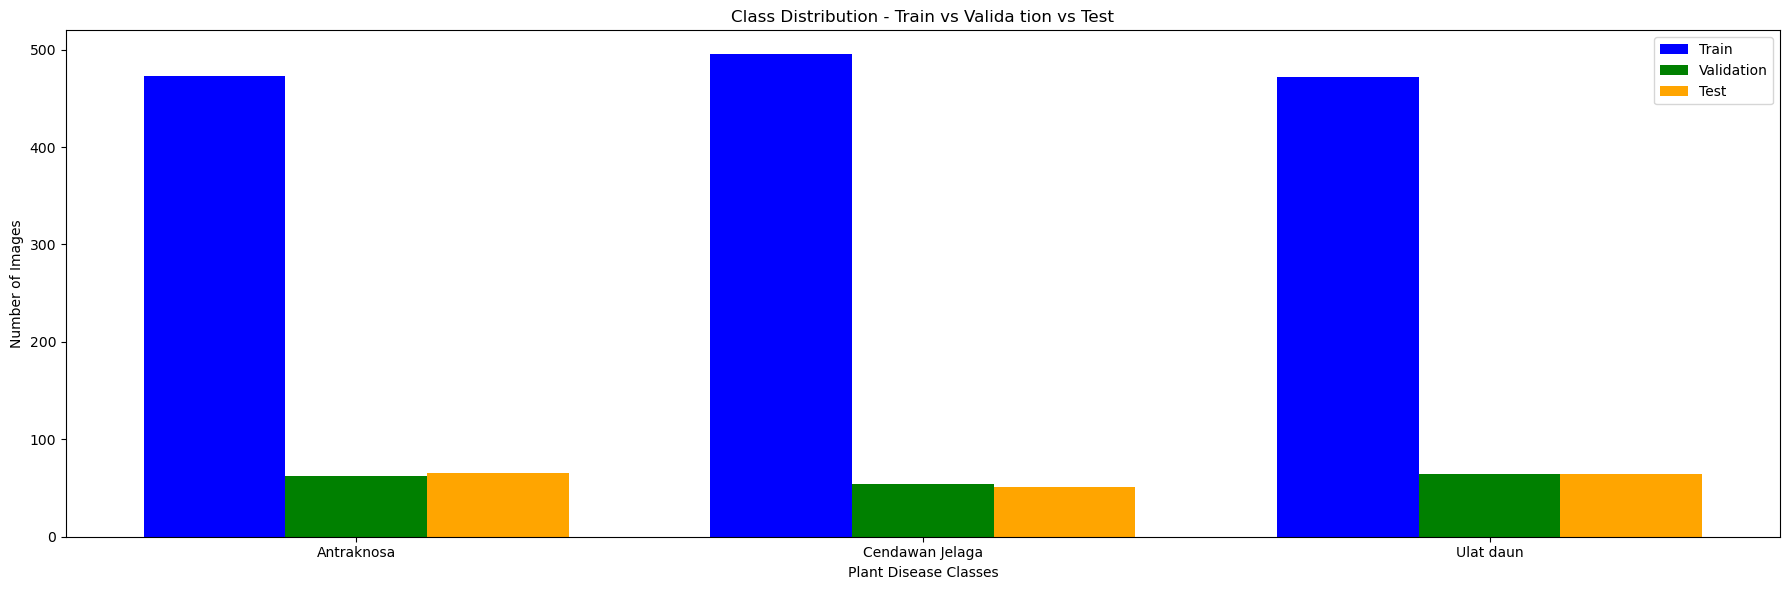

In [10]:
# Menghitung jumlah sampel per kelas untuk data pelatihan, validasi, dan pengujian
train_class_counts = np.bincount(train_labels)  # Jumlah sampel kelas untuk data pelatihan
val_class_counts = np.bincount(val_labels, minlength=len(all_labels))  # Jumlah sampel kelas untuk data validasi
test_class_counts = np.bincount(test_labels, minlength=len(all_labels))  # Jumlah sampel kelas untuk data pengujian

# Mendefinisikan label kelas yang digunakan dalam dataset
classes = all_labels  # Label kelas

# Warna batang untuk setiap subset
train_colors = 'blue'      # Warna batang untuk data pelatihan
val_colors = 'green'       # Warna batang untuk data validasi
test_colors = 'orange'     # Warna batang untuk data pengujian

# Lebar batang grafik
bar_width = 0.25  # Lebar batang grafik
index = np.arange(len(classes))  # Posisi batang
plt.figure(figsize=(18, 6))  # Ukuran gambar

# Membuat grafik batang untuk distribusi data pelatihan
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')  # Grafik batang untuk data pelatihan

# Membuat grafik batang untuk distribusi data validasi
plt.bar(index + bar_width, val_class_counts, width=bar_width, color=val_colors, label='Validation')  # Grafik batang untuk data validasi

# Membuat grafik batang untuk distribusi data pengujian
plt.bar(index + 2 * bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')  # Grafik batang untuk data pengujian
plt.xlabel("Plant Disease Classes")  # Label untuk sumbu X
plt.ylabel("Number of Images")  # Label untuk sumbu Y
plt.title("Class Distribution - Train vs Valida tion vs Test")  # Judul grafik
plt.xticks(index + bar_width, classes)  # Label kelas pada sumbu X
plt.legend()  # Menampilkan legenda

# Menyesuaikan tata letak agar semua elemen terlihat dengan baik
plt.tight_layout()  # Menyesuaikan layout
plt.show()  # Menampilkan grafik

# Pre Processing Data

In [11]:
# Normalize image data (convert pixel values to range 0-1)
x_train = np.array(train_images, dtype=np.float16) / 255.0  # Normalisasi data pelatihan
x_val = np.array(val_images, dtype=np.float16) / 255.0      # Normalisasi data validasi
x_test = np.array(test_images, dtype=np.float16) / 255.0    # Normalisasi data pengujian

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))  # One-hot encoding untuk data pelatihan
y_val = to_categorical(np.array(val_labels), num_classes=len(classes))      # One-hot encoding untuk data validasi
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))    # One-hot encoding untuk data pengujian

# Menampilkan bentuk (shape) data untuk pelatihan, validasi, dan pengujian
print("x_train shape:", x_train.shape)  # Dimensi data pelatihan
print("x_val shape:", x_val.shape)      # Dimensi data validasi
print("x_test shape:", x_test.shape)    # Dimensi data pengujian
print("y_train shape:", y_train.shape)  # Dimensi label pelatihan
print("y_val shape:", y_val.shape)      # Dimensi label validasi
print("y_test shape:", y_test.shape)    # Dimensi label pengujian


x_train shape: (1440, 128, 128, 3)
x_val shape: (180, 128, 128, 3)
x_test shape: (180, 128, 128, 3)
y_train shape: (1440, 3)
y_val shape: (180, 3)
y_test shape: (180, 3)


# Visualization

# a. Sample Train Images

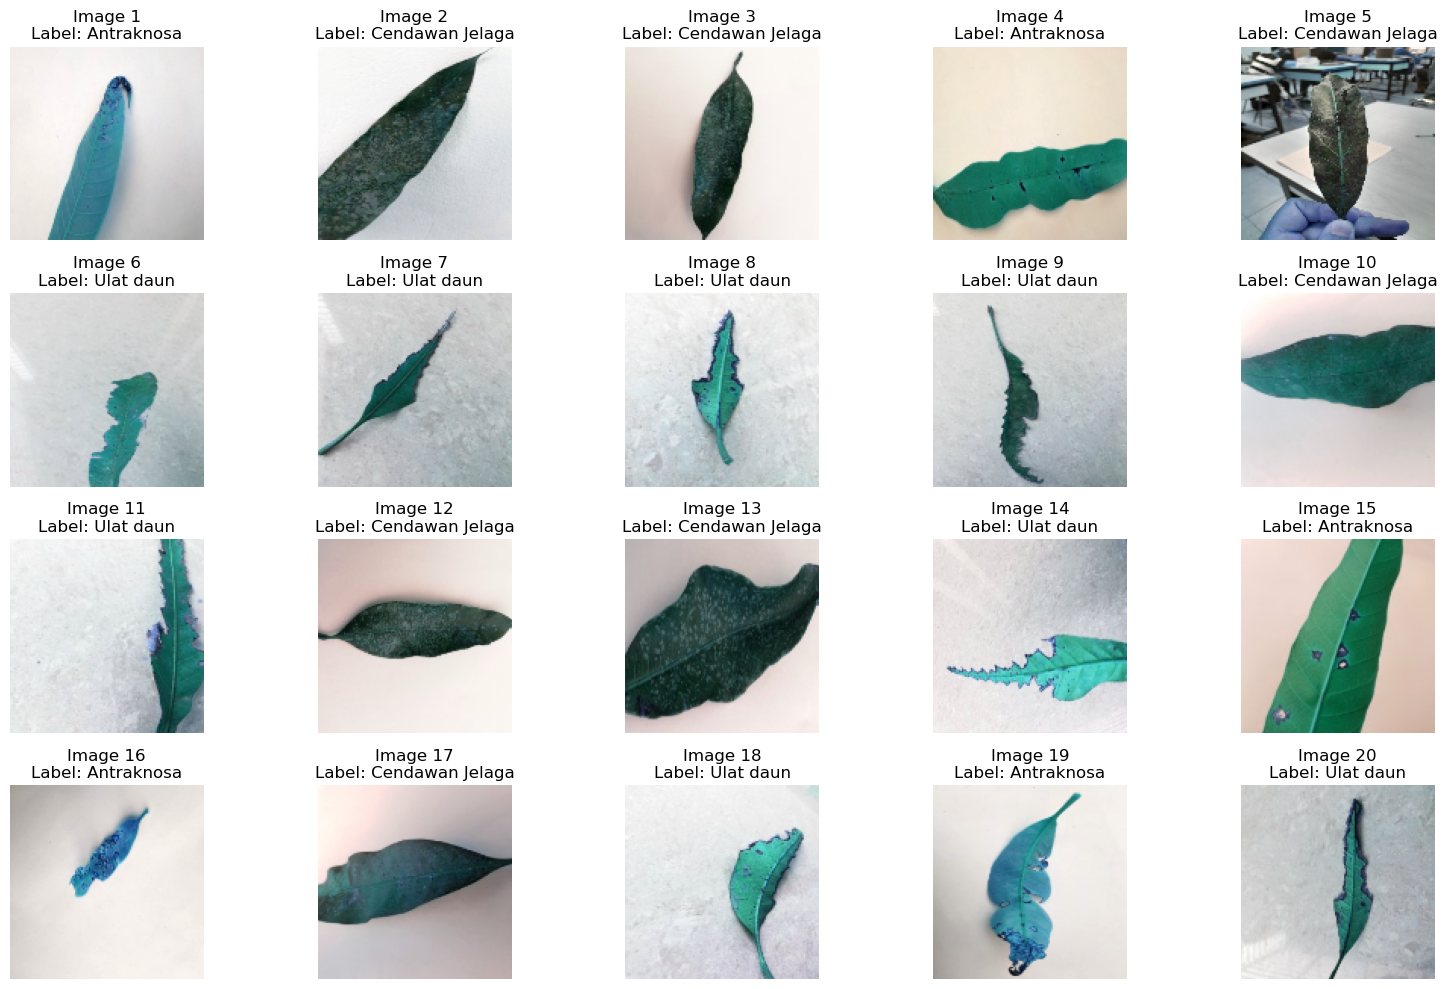

In [12]:
# Visualisasi 20 gambar sample dari training set
plt.figure(figsize=(16, 10))

# Ambil 20 indeks acak dari data latih
sample_indices = random.sample(range(len(x_train)), 20)

# Loop untuk menampilkan gambar
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))  # Menampilkan gambar
    label = np.argmax(y_train[idx])  # Menentukan label dengan one-hot encoding
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")  # Menampilkan judul dengan label
    plt.axis('off')  # Menyembunyikan axis

plt.tight_layout()
plt.show()

# b. Sample Test Images

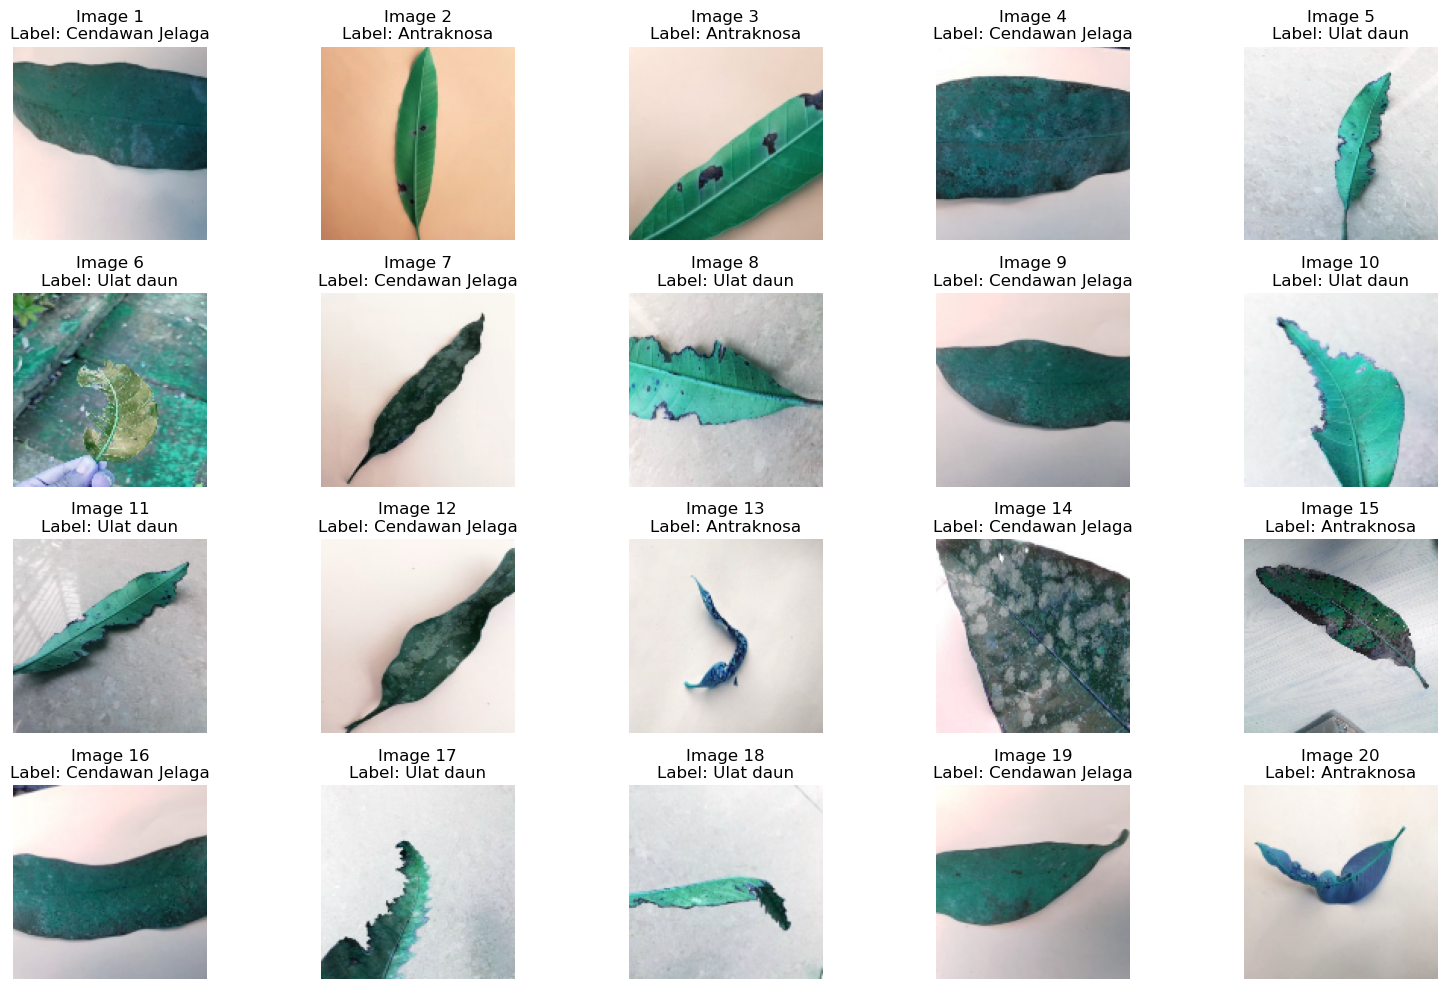

In [13]:
# Visualisasi 20 gambar sampel dari test set
plt.figure(figsize=(16, 10))

# Ambil 20 indeks acak dari data uji
sample_indices = random.sample(range(len(x_test)), 20)

# Loop untuk menampilkan gambar
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))  # Menampilkan gambar
    label = np.argmax(y_test[idx])  # Menentukan label dengan one-hot encoding
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")  # Menampilkan judul dengan label
    plt.axis('off')  # Menyembunyikan axis

plt.tight_layout()
plt.show()

# Model Definition

# c. Sample Validation Images

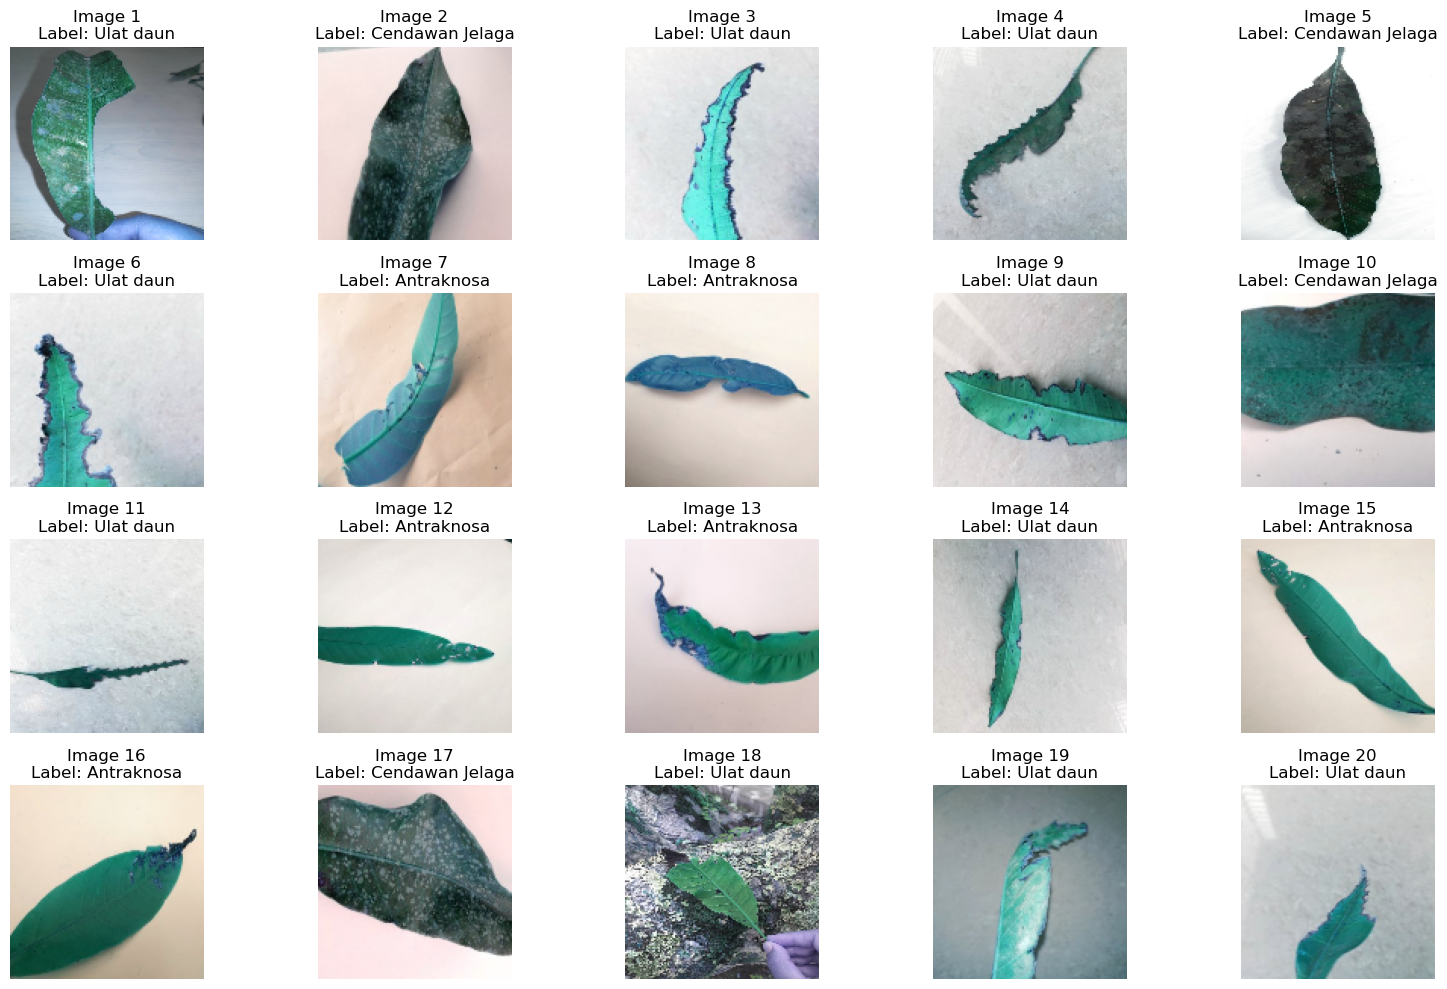

In [14]:
# Menampilkan 20 sampel gambar dari data validasi
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_val)), 20)  # Pilih 20 sampel secara acak dari data validasi

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)  # Menyusun gambar dalam grid 4x5
    plt.imshow(array_to_img(x_val[idx]))  # Menampilkan gambar dari data validasi
    label = np.argmax(y_val[idx])  # Mengambil label satu-hot encoding
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")  # Menambahkan judul dengan label kelas
    plt.axis('off')  # Menyembunyikan axis pada gambar
plt.tight_layout()  # Menata layout gambar
plt.show()  # Menampilkan gambar


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Model ResNet50
def build_resnet50_model(input_shape=(128, 128, 3), num_classes=3):
    # Menggunakan ResNet50 tanpa top (fully connected layers)
    base_model = ResNet50(include_top=False, input_shape=input_shape)
    
    # Membuat model dengan layers tambahan setelah base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Menggunakan global average pooling
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer
        Dropout(0.6),  # Dropout untuk mencegah overfitting
        Dense(num_classes, activation='softmax')  # Output layer dengan softmax untuk multi-class classification
    ])
    
    return model

# Contoh penggunaan
resnet50_model = build_resnet50_model(input_shape=(128, 128, 3), num_classes=3)
resnet50_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 25,635,843 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Model Training

Training ResNet50 model...
Epoch 1/30


C:\Users\USER\anaconda2\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.4212 - loss: 14.9420 - val_accuracy: 0.3438 - val_loss: 14.7956
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7387 - loss: 14.1944 - val_accuracy: 0.3715 - val_loss: 15.1361
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8687 - loss: 13.7994 - val_accuracy: 0.3993 - val_loss: 15.2772
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 946ms/step - accuracy: 0.8953 - loss: 13.6019 - val_accuracy: 0.4062 - val_loss: 15.2935
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 926ms/step - accuracy: 0.9144 - loss: 13.4136 - val_accuracy: 0.3889 - val_loss: 15.0382
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 929ms/step - accuracy: 0.9300 - loss: 13.2620 - val_accuracy: 0.2986 - val_loss: 14.7613
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 934ms/step - accuracy: 0.9194 - loss: 13.1406 - val_accuracy: 0.2743 - val_loss: 14.4370
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9479 - loss: 12.9494 - val_accuracy: 0

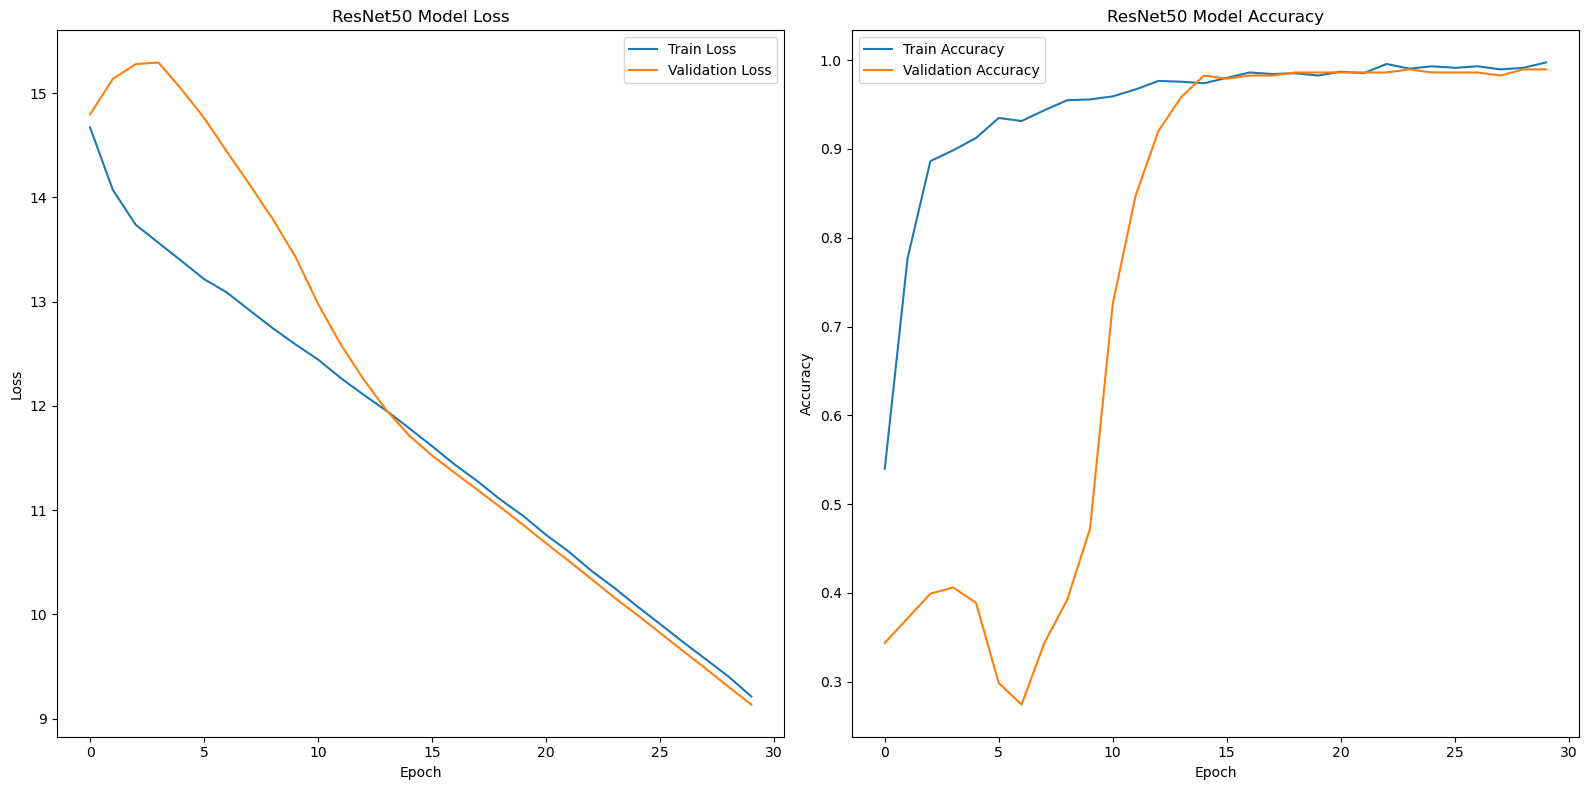

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Model ResNet50
def build_resnet50_model(input_shape=(128, 128, 3), num_classes=3):
    base_model = ResNet50(include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Definisi ImageDataGenerator untuk augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training ResNet50
print("Training ResNet50 model...")
resnet50_model = build_resnet50_model(input_shape=(128, 128, 3), num_classes=3)
resnet50_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_resnet50 = resnet50_model.fit(
    datagen.flow(x_train, y_train, batch_size=16),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

# Save model and history
history_dict_resnet50 = history_resnet50.history

# Plot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# Loss
ax[0].plot(history_dict_resnet50['loss'], label='Train Loss')
ax[0].plot(history_dict_resnet50['val_loss'], label='Validation Loss')
ax[0].set_title('ResNet50 Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
# Accuracy
ax[1].plot(history_dict_resnet50['accuracy'], label='Train Accuracy')
ax[1].plot(history_dict_resnet50['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('ResNet50 Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


Evaluating ResNet50 model on test data...
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 520ms/step - accuracy: 0.9857 - loss: 9.1582
Test Loss: 9.1431
Test Accuracy: 0.9889
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 

Classification Report:
                 precision    recall  f1-score   support

     Antraknosa       1.00      0.97      0.98        65
Cendawan Jelaga       1.00      1.00      1.00        51
      Ulat daun       0.97      1.00      0.98        64

       accuracy                           0.99       180
      macro avg       0.99      0.99      0.99       180
   weighted avg       0.99      0.99      0.99       180



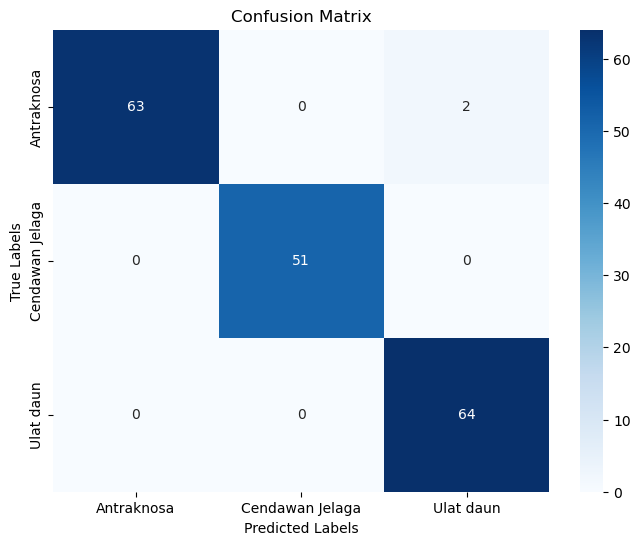

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluasi model menggunakan data test
print("Evaluating ResNet50 model on test data...")
test_loss, test_accuracy = resnet50_model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Prediksi data test
y_pred_probs = resnet50_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Ambil kelas dengan probabilitas tertinggi
y_true = np.argmax(y_test, axis=1)        # Ambil kelas sebenarnya dari one-hot encoding

# Laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Matriks kebingungan (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)

# Visualisasi matriks kebingungan
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [18]:
import cv2
import numpy as np

def preprocess_for_display(image):
    """
    Pastikan gambar berada di RGB dan rentang nilai [0, 255].
    """
    # Jika gambar normalisasi dalam rentang [0, 1], ubah ke [0, 255]
    if np.max(image) <= 1.0:
        image = image * 255
    # Pastikan format uint8
    image = image.astype("uint8")
    # Konversi BGR ke RGB jika menggunakan OpenCV
    if image.shape[-1] == 3:  # Jika gambar memiliki 3 channel
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [19]:
# Daftar nama kelas
classes = ['Antraknosa', 'Cendawan Jelaga', 'Ulat Daun']  # Sesuaikan dengan model Anda

In [20]:
def output_plot(image, model, classes):
    """
    Menampilkan gambar input dan prediksi dari model.
    """
    # Preprocessing gambar untuk ditampilkan
    image_display = preprocess_for_display(image)
    
    plt.imshow(image_display)
    plt.axis('off')
    
    # Prediksi
    prediction = model.predict(np.expand_dims(image, axis=0))  # Tambahkan dimensi batch
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()




Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


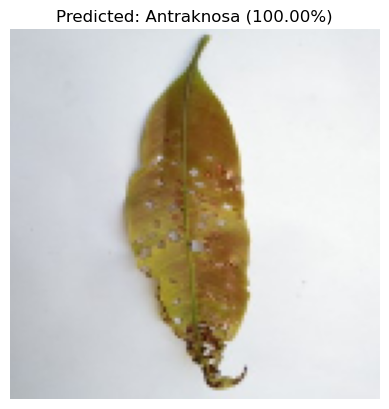



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


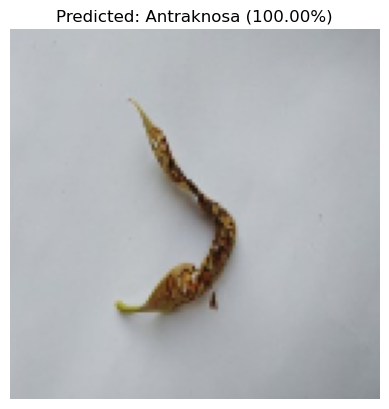



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


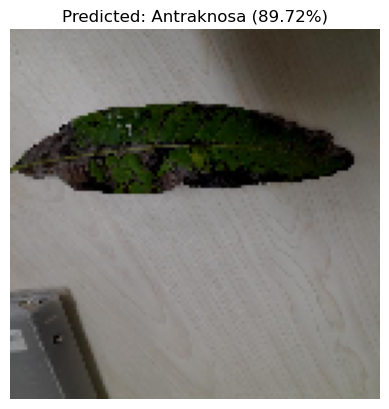



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


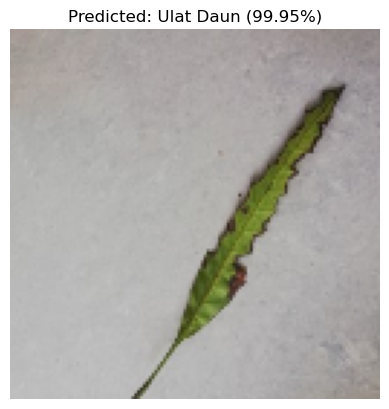



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


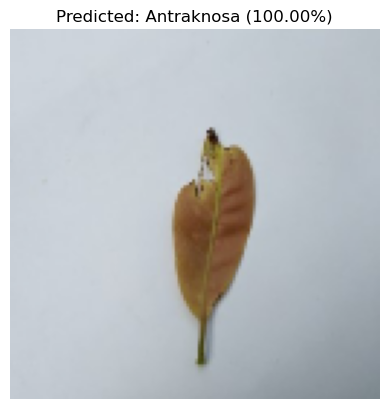



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


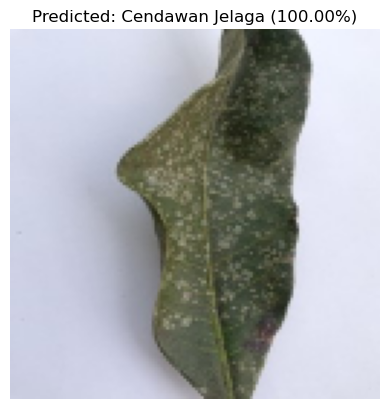



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


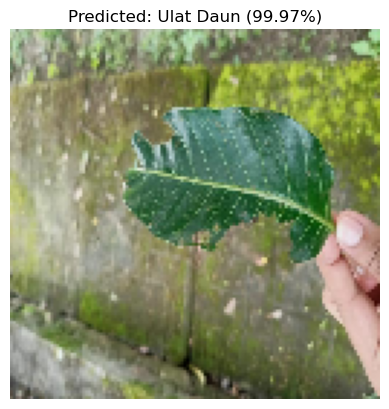



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


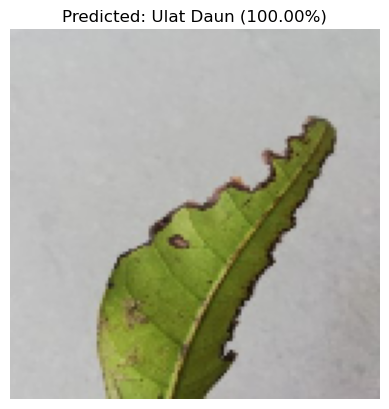



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


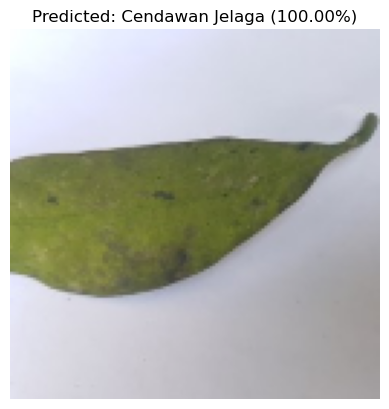



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


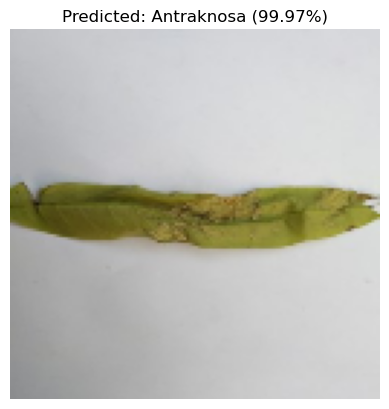



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


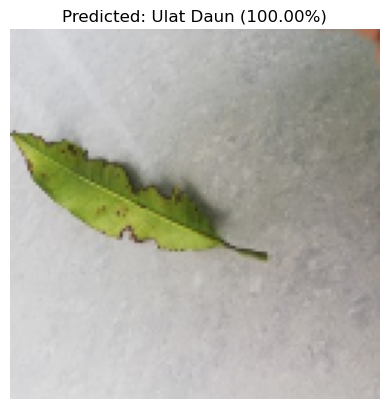



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


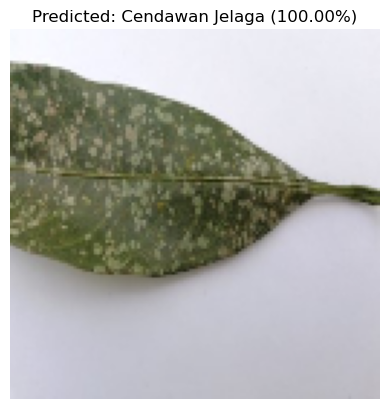



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


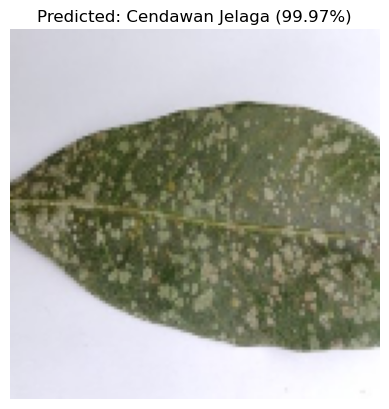



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


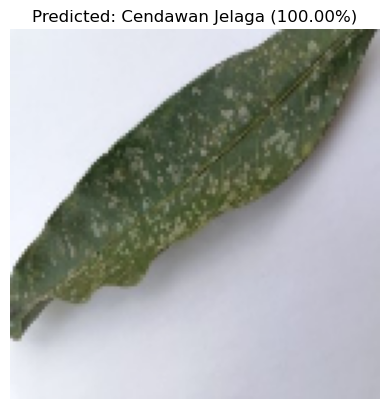



Testing - resnet50 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


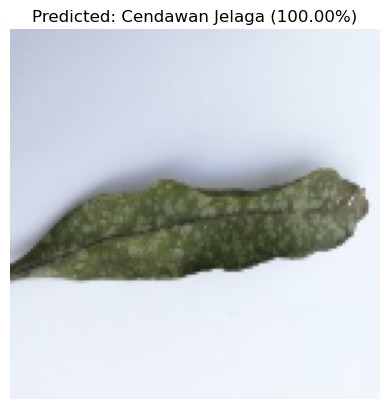

In [21]:
# Testing untuk beberapa gambar dari dataset uji
for i in range(20, 35):  # Pilih indeks gambar uji
    print(f"\n\nTesting - resnet50 Model\n")
    output_plot(x_test[i], resnet50_model, classes)

In [22]:
model = build_resnet50_model()  # Panggil fungsi untuk membangun model
model.save_weights('model_resnet50.weights.h5')  # Simpan bobot model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


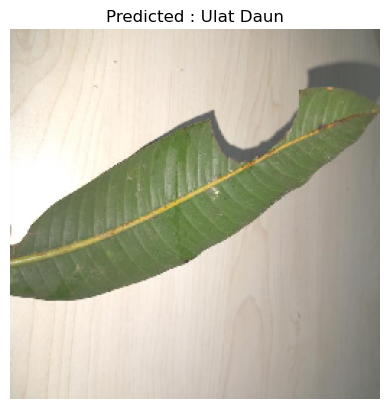

In [22]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Tetapkan label kelas secara manual
class_labels = ['Antraknosa', 'Cendawan Jelaga', 'Ulat Daun']  # Ganti dengan label yang sesuai

# Muat model dan bobot
model_path = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/model_resnet50.weights.h5'
model = build_resnet50_model()  
model.load_weights(model_path)

def predict_and_display(image_path, model, class_labels):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted : {predicted_class_label}")
    plt.show()

# Path ke gambar uji
image_path_to_test = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/Ulat daun/20241111_210658_jpg.rf.bb27959083bbc252b8612455d0b08a0b.jpg'

# Prediksi dan tampilkan hasil
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


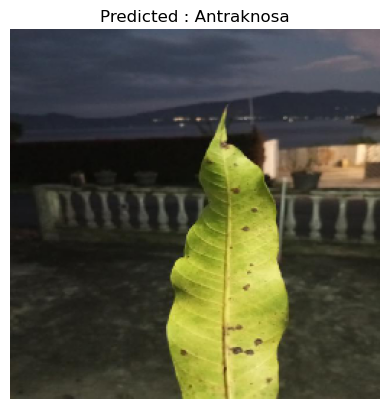

In [23]:
image_path_to_test = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/antraknosa/16e49d55-a1d4-4d0c-ba6c-3d366ff98026_jpg.rf.46366b17a5ed4c570bb72bf13fd21e26.jpg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


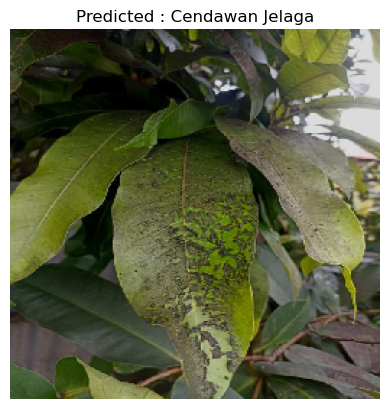

In [24]:
image_path_to_test = 'D:/MATA KULIAH/SEMESTER 5/PM/Week 14/Praktikum/Cendawan Jelaga/WhatsApp-Image-2024-10-29-at-09-42-10-1-_jpeg.rf.20e261df2dcc1c39d64340b67b31751a.jpg'
predict_and_display(image_path_to_test, model, class_labels)